![taxi image](taxi.jpg)
# Dynamic Taxi Pricing with ML
### *Innovents Hackathon Submission - Kelly Hopkins*

# Problem Statement:

> *As part of the agency’s commitment to encourage innovation in the for-hire vehicle industry, DFHV seeks to introduce a dynamic pricing system for taxi cabs. DFHV wants to implement three pricing tiers (eg, off-peak-normal-peak, or low-medium-high) based on trip data. The tiers could be based on times or areas that have more or less demand for taxi cab service. As the taxi cab regulator, DFHV sets taxi cab rates and would establish parameters for dynamic pricing, which taxi cabs would follow.*

link to the kaggle dataset: https://www.kaggle.com/bvc5283/dc-taxi-trips

# Solution: 
Apply machine learning techniques to the taxi trips dataset to adjust pricing based on relative demand.

Concepts explored in this presentation:
- Tiered-based time clustering
- Hourly time aggregation
- Historical modeling using Linear Regression

In [1]:
# data analysis packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import os
from datetime import datetime

import folium 
import branca
from folium import plugins
from folium.plugins import HeatMap

# ML algorithms
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor

from collections import defaultdict

#display settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set working directory
os.chdir(r'C:\Users\kah32\Documents\Code Projects\Dynamic Taxi Pricing')
%pwd

'C:\\Users\\kah32\\Documents\\Code Projects\\Dynamic Taxi Pricing'

# Sampling the Data Set

In [2]:
#Generate random sample of data file using 'shuf -n 10000 taxi_final.csv > taxi_sample.csv' bash command
#Take column names from original file and add to sample file

path = "dc-taxi-trips/taxi_sample7.csv"
header = pd.read_csv("dc-taxi-trips/taxi_final.csv", header=0, nrows=0)
h = pd.Series(list(header))
taxi = pd.read_csv(path, header=None, parse_dates=True)
taxi.columns = h
taxi.head()
taxi.columns


,Type,PROVIDER NAME,StartDateTime,DateCreated,ID,ExternalID,FareAmount,GratuityAmount,SurchargeAmount,ExtraFareAmount,...,DestinationStreetNumber,DestinationStreetName,DestinationCity,DestinationState,DestinationZip,DestinationLatitude,DestinationLongitude,Milage,Duration,Unnamed: 31
0,1.0,Bay Cab,2017-09-15 23:45:59.8810000 +00:00,2017-09-15 23:45:59.8810000 +00:00,75332_26IMIN0F,75332_26IMIN0F,17.02,0.0,0.25,1.0,...,-,-,-,--,-----,38.900375,-76.988367,3.05,1416.0,NaN
1,1.0,VeriFone,2017-04-19 23:50:00.0000000 +00:00,2017-04-21 09:42:22.5300000 +00:00,E632__65329__2017-04-21T09:42:22.530_30551277,30551277,14.32,0.0,0.25,0.0,...,NaN,4019 Minnesota Ave Ne,Washington,DC,20019,38.895720,-76.948590,4.18,16.0,NaN
2,1.0,UVC,2017-03-31 21:16:00.0000000 +00:00,2017-03-31 21:27:07.0566667 +00:00,G817__76572__2017-03-31T21:27:07.057_29752872,29752872,7.30,2.0,0.25,3.0,...,NaN,2314-2324 S Clark St,Arlington,VA,22202,38.853150,-77.052240,1.50,7.0,NaN
3,1.0,Bay Cab,2017-10-14 18:27:34.1860000 +00:00,2017-10-14 18:27:34.1860000 +00:00,73283_26K9FFWU,73283_26K9FFWU,11.35,0.0,0.25,0.0,...,-,-,-,--,-----,38.883991,-77.064572,2.24,737.0,NaN
4,1.0,Hitch,2017-06-21 16:01:15.0000000 +00:00,2017-06-22 04:43:24.3866667 +00:00,F529__81317__2017-06-22T04:43:24.387_32897547,32897547,13.50,0.0,0.25,0.0,...,NaN,NaN,Washington,DC,20004,38.890000,-77.010000,0.00,NaN,NaN


Index(['Type', 'PROVIDER NAME', 'StartDateTime', 'DateCreated', 'ID',
       'ExternalID', 'FareAmount', 'GratuityAmount', 'SurchargeAmount',
       'ExtraFareAmount', 'TollAmount', 'TotalAmount', 'PaymentType',
       'StartDateTime.1', 'EndDateTime', 'OriginStreetNumber',
       'OriginStreetName', 'OriginCity', 'OriginState', 'OriginZip',
       'OriginLatitude', 'OriginLongitude', 'DestinationStreetNumber',
       'DestinationStreetName', 'DestinationCity', 'DestinationState',
       'DestinationZip', 'DestinationLatitude', 'DestinationLongitude',
       'Milage', 'Duration', 'Unnamed: 31'],
      dtype='object')

# EDA, Data Cleansing, and Feature Engineering

In [3]:
# Convert date columns to proper dtypes

taxi['StartDateTime'] = pd.to_datetime(taxi['StartDateTime'], errors='coerce')
taxi['EndDateTime'] = pd.to_datetime(taxi['EndDateTime'], errors='coerce')

taxi.dtypes

Type                                   float64
PROVIDER NAME                           object
StartDateTime              datetime64[ns, UTC]
DateCreated                             object
ID                                      object
ExternalID                              object
FareAmount                             float64
GratuityAmount                         float64
SurchargeAmount                        float64
ExtraFareAmount                        float64
TollAmount                             float64
TotalAmount                            float64
PaymentType                            float64
StartDateTime.1                         object
EndDateTime                datetime64[ns, UTC]
OriginStreetNumber                      object
OriginStreetName                        object
OriginCity                              object
OriginState                             object
OriginZip                               object
OriginLatitude                         float64
OriginLongitu

In [4]:
# Data cleanup

# Drop useless columns
taxi.drop(['DateCreated', 'StartDateTime.1', 'Unnamed: 31'], axis=1, inplace=True)

# Remove negative and wrong values
taxi = taxi[taxi['FareAmount'] > 0]
taxi = taxi[taxi['GratuityAmount'] >= 0]
taxi = taxi[taxi['SurchargeAmount'] >= 0]
taxi = taxi[taxi['ExtraFareAmount'] >= 0]
taxi = taxi[taxi['TotalAmount'] > 0]
taxi = taxi[taxi['Milage'] > 0]
taxi = taxi[taxi['Milage'] < 500]
taxi = taxi[taxi['Duration'] > 0]
taxi = taxi[taxi['Duration'] < 480]

# exclude rides under 1 mile/hour
taxi = taxi[taxi['Duration'] / taxi['Milage'] < 60]
#exclude rides over 1.5 miles/minute (90 mph)
taxi = taxi[taxi['Milage'] / taxi['Duration'] < 1.5]

taxi.shape

(146328, 29)

In [5]:
# Parse Datetimes into more time options
taxi['Date'] = taxi['StartDateTime'].dt.date
taxi['Hour'] = taxi['StartDateTime'].dt.hour
taxi['Weekday'] = taxi['StartDateTime'].dt.weekday
taxi['DayofWeek'] = taxi['StartDateTime'].dt.weekday_name
taxi['Time'] = taxi['StartDateTime'].dt.strftime("%I:%M %p")
# Classify weekdays and weekend
#x = 0
#taxi['IsWeekday'] = [x+1 if i<6 else x for i in taxi['Weekday']]
taxi['IsWeekday'] = [0 if i in ['Saturday', 'Sunday'] else 1 for i in taxi['DayofWeek']]

# Remove nulls and wrong values
taxi['StartDateTime'].dropna(inplace=True)
taxi = taxi[taxi['StartDateTime'] < taxi['EndDateTime']]

taxi.head()

,Type,PROVIDER NAME,StartDateTime,ID,ExternalID,FareAmount,GratuityAmount,SurchargeAmount,ExtraFareAmount,TollAmount,...,DestinationLatitude,DestinationLongitude,Milage,Duration,Date,Hour,Weekday,DayofWeek,Time,IsWeekday
1,1.0,VeriFone,2017-04-19 23:50:00+00:00,E632__65329__2017-04-21T09:42:22.530_30551277,30551277,14.32,0.0,0.25,0.0,0.0,...,38.89572,-76.94859,4.18,16.0,2017-04-19,23,2,Wednesday,11:50 PM,1
2,1.0,UVC,2017-03-31 21:16:00+00:00,G817__76572__2017-03-31T21:27:07.057_29752872,29752872,7.30,2.0,0.25,3.0,0.0,...,38.85315,-77.05224,1.50,7.0,2017-03-31,21,4,Friday,09:16 PM,1
5,1.0,Transco,2017-02-08 12:40:00+00:00,D403__77526__2017-02-09T07:34:31.417_27516038,27516038,6.76,1.4,0.25,0.0,0.0,...,38.89256,-77.01279,0.94,7.0,2017-02-08,12,2,Wednesday,12:40 PM,1
6,1.0,CMT,2017-07-12 09:43:41.856666700+00:00,C132__70120__2017-07-13T21:31:00.777_33618778,33618778,9.19,0.0,0.25,1.0,0.0,...,38.89119,-77.00606,2.00,11.0,2017-07-12,9,2,Wednesday,09:43 AM,1
7,1.0,Transco,2017-03-22 16:40:00+00:00,K880__81976__2017-03-23T18:08:22.787_29235058,29235058,7.03,0.0,0.25,0.0,0.0,...,38.94424,-76.98665,1.50,6.0,2017-03-22,16,2,Wednesday,04:40 PM,1


# Exploring Our New Feature Set

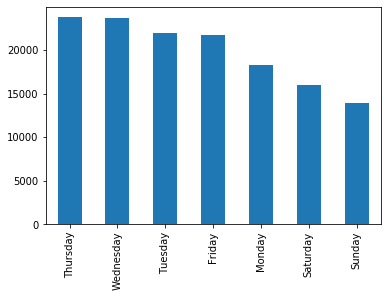

In [6]:
# Breakdown of rides by day
taxi['DayofWeek'].value_counts().plot(kind='bar')

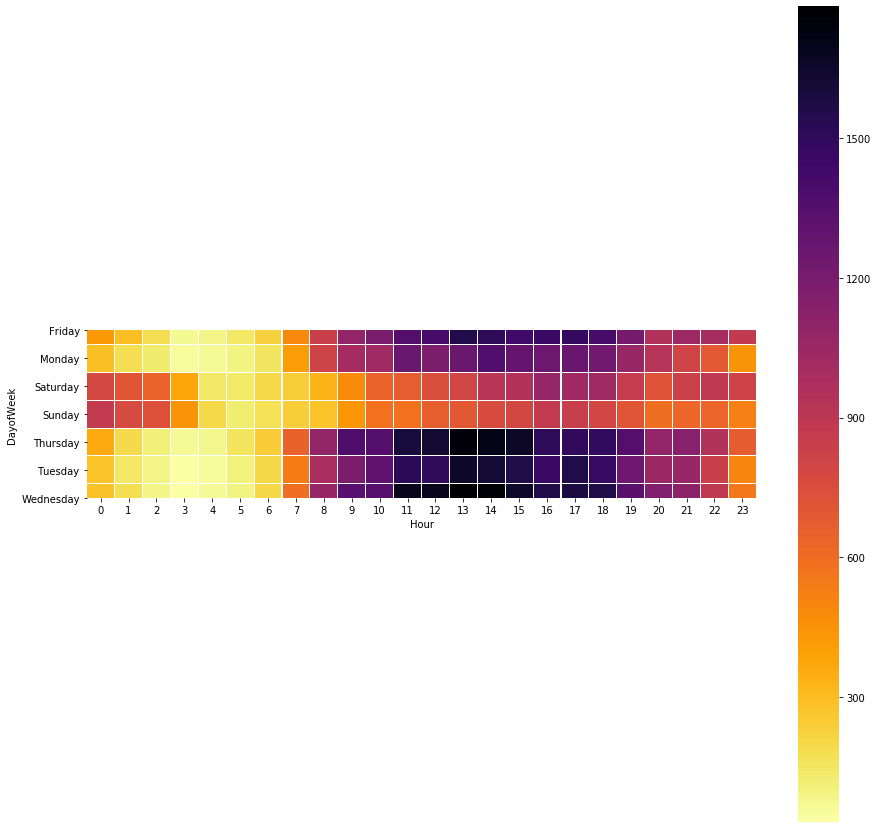

In [7]:
# Breadown of demand into weekly time table
time_map=pd.pivot_table(taxi,index=['DayofWeek'],columns =['Hour'],aggfunc='size')
fig, ax = plt.subplots(figsize=(15,15)) 
ax=sb.heatmap(time_map,linewidths=0.1,square=True,cmap='inferno_r')

# Creating Off-Peak, Normal, and Peak Pricing Tiers (Weekday and Weekend) Using K-means Clustering Algorithm

## Process:
1. Separate data into weekday and weekend rides
2. Calculate number of rides per hour (demand)
3. Apply K-means clustering to hour groups to get 3 clusters/pricing groups

In [8]:
# label weekday
df1 = pd.DataFrame(taxi[taxi['IsWeekday']==1]['Hour'].value_counts().sort_index())
df1 = df1.reset_index()
df1.columns = ['Hour', 'Demand']

kmeans_wd = KMeans(n_clusters=3).fit(df1)
df1['WeekdayLabel'] = kmeans_wd.labels_

df1

df2 = pd.DataFrame(taxi[taxi['IsWeekday']==0]['Hour'].value_counts().sort_index())
df2 = df2.reset_index()
df2.columns = ['Hour', 'Demand']

kmeans_we = KMeans(n_clusters=3).fit(df2)
df2['WeekendLabel'] = kmeans_we.labels_

df2

,Hour,Demand,WeekdayLabel
0,0,1636,0
1,1,1001,0
2,2,603,0
3,3,255,0
4,4,361,0
5,5,603,0
6,6,1043,0
7,7,2690,2
8,8,4781,2
9,9,6002,1


,Hour,Demand,WeekendLabel
0,0,1649,2
1,1,1485,0
2,2,1381,0
3,3,820,1
4,4,344,1
5,5,263,1
6,6,367,1
7,7,480,1
8,8,609,1
9,9,915,1


# Calculating Surge Pricing Multipliers for our 3 Pricing Tiers

## What are Multipliers?

> *The taxi’s surge charge is designed to maintain a balance between supply and demand. As the surge price multiplier increases, the number of people willing to pay the surge fee decreases. When done right, the result creates a perfect marketplace, where there enough taxis to satisfy the demand.*

> *As prices rise in an area, other taxis arrive, increasing the supply of drivers serving the market. The additional drivers increase the supply of rides available, which helps to push the surge price multiplier down.*

> *Taxi drivers are more motivated to drive during peak hours, as the extra fees mean they earn more money. This motivation further helps to increase the supply of drivers during periods of high demand.*

source - https://www.quicklizard.com/2019/11/27/surge-pricing-your-taxi/

In [33]:
#co-ordinates
LaGuardia = {
    "minLat": 38.81,
    "maxLat": 38.99,
    "minLong": -77.123,
    "maxLong": -76.906
}
#taxi['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
#taxi['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

LaGuardiaData = taxi[(taxi['OriginLongitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = taxi[(taxi['OriginLatitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]
LaGuardiaData = taxi[(taxi['DestinationLongitude'].apply(lambda x: (x >=LaGuardia["minLong"]) & (x <= LaGuardia["maxLong"])))]
LaGuardiaData = taxi[(taxi['DestinationLatitude'].apply(lambda x: (x >=LaGuardia["minLat"]) & (x <= LaGuardia["maxLat"])))]

m = folium.Map(
    location=[38.898, -77.027],
    zoom_start=12,
    tiles='cartodbdark_matter'
)
folium.Marker(location=[38.898, -77.027],icon=folium.Icon(color='black') ,popup='LA Guardia International Airport').add_to(m)

#shortTripsDF=LaGuardiaData[LaGuardiaData.trip_duration==900]

lines = [
    {
        'coordinates': [
            [taxi.OriginLongitude.iloc[index], taxi.OriginLatitude.iloc[index]],
            [taxi.DestinationLongitude.iloc[index], taxi.DestinationLatitude.iloc[index]],
        ],
        'dates': [
        str(taxi.StartDateTime.iloc[index]),
        str(taxi.EndDateTime.iloc[index])
        ],
        'color': 'gold'
    }
    for index in range(1000)
]
features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
        },
        'properties': {
            'times': line['dates'],
            'style': {
                'color': line['color'],
                'weight': 1 #line['weight'] if 'weight' in line else 10
            }
        }
    }
    for line in lines
]


plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT24H', add_last_point=True).add_to(m)
m

In [10]:
weekday_tiers = df1.copy()
weekday_tiers = weekday_tiers[['Demand', 'WeekdayLabel']].groupby('WeekdayLabel').sum().sort_values(by='Demand').reset_index()
weekday_tiers['Mult'] = weekday_tiers['Demand'] / weekday_tiers['Demand'].median()
weekday_tiers

weekend_tiers = df2.copy()
weekend_tiers = weekend_tiers[['Demand', 'WeekendLabel']].groupby('WeekendLabel').sum().sort_values(by='Demand').reset_index()
weekend_tiers['Mult'] = weekend_tiers['Demand'] / weekend_tiers['Demand'].median()
weekend_tiers

,WeekdayLabel,Demand,Mult
0,0,5502,0.217729
1,2,25270,1.000000
2,1,78620,3.111199


,WeekendLabel,Demand,Mult
0,1,3798,0.354523
1,2,10713,1.000000
2,0,15478,1.444787


# Exploring Hour-Based Multipliers

In [11]:
wd_hour_tiers = df1.groupby('Hour').sum()
wd_hour_tiers['WDHourMult'] = wd_hour_tiers['Demand'] / wd_hour_tiers['Demand'].median()
wd_hour_tiers = wd_hour_tiers.reset_index()
wd_hour_tiers

we_hour_tiers = df2.groupby('Hour').sum()
we_hour_tiers['WEHourMult'] = we_hour_tiers['Demand'] / we_hour_tiers['Demand'].median()
we_hour_tiers = we_hour_tiers.reset_index()
we_hour_tiers

,Hour,Demand,WeekdayLabel,WDHourMult
0,0,1636,0,0.315769
1,1,1001,0,0.193206
2,2,603,0,0.116387
3,3,255,0,0.049218
4,4,361,0,0.069678
5,5,603,0,0.116387
6,6,1043,0,0.201312
7,7,2690,2,0.519205
8,8,4781,2,0.922795
9,9,6002,1,1.158464


,Hour,Demand,WeekendLabel,WEHourMult
0,0,1649,2,1.182503
1,1,1485,0,1.064898
2,2,1381,0,0.990319
3,3,820,1,0.588024
4,4,344,1,0.246683
5,5,263,1,0.188598
6,6,367,1,0.263177
7,7,480,1,0.344209
8,8,609,1,0.436716
9,9,915,1,0.656149


# Plotting Time vs. Multipliers

<Figure size 1080x720 with 0 Axes>

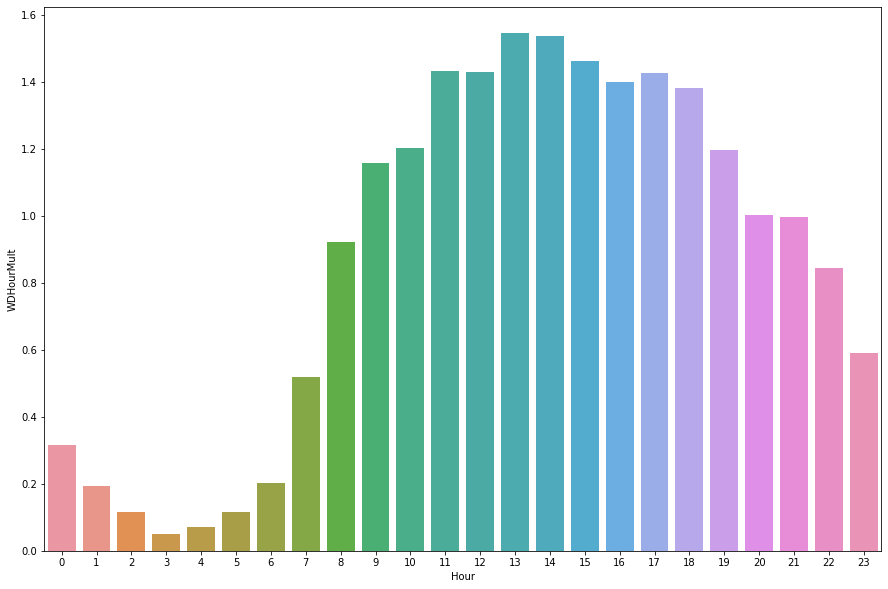

In [12]:
# Weekday Demand
plt.figure(figsize=(15,10))
sb.barplot(x='Hour', y='WDHourMult', data=wd_hour_tiers)

<Figure size 1080x720 with 0 Axes>

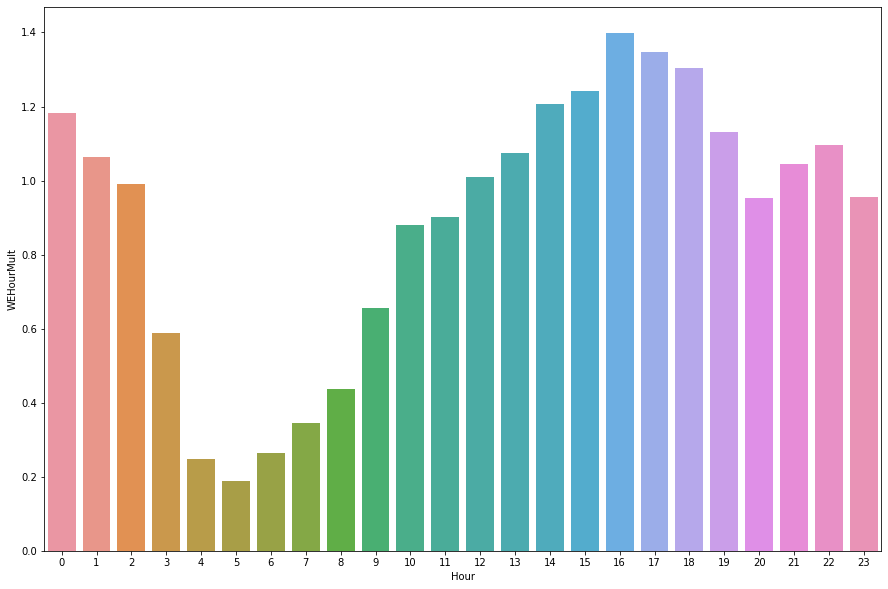

In [13]:
# Weekend Demand
plt.figure(figsize=(15,10))
sb.barplot(x='Hour', y='WEHourMult', data=we_hour_tiers)

In [14]:
# Merge labels
df1 = df1.loc[:,['Hour', 'WeekdayLabel']]
df2 = df2.loc[:,['Hour', 'WeekendLabel']]

taxi = taxi.merge(df1, on = 'Hour')
taxi = taxi.merge(df2, on = 'Hour')

taxi = taxi.merge(wd_hour_tiers.loc[:,['Hour', 'WDHourMult']], on='Hour')
taxi = taxi.merge(we_hour_tiers.loc[:,['Hour', 'WEHourMult']], on='Hour')

taxi.head()

,Type,PROVIDER NAME,StartDateTime,ID,ExternalID,FareAmount,GratuityAmount,SurchargeAmount,ExtraFareAmount,TollAmount,...,Date,Hour,Weekday,DayofWeek,Time,IsWeekday,WeekdayLabel,WeekendLabel,WDHourMult,WEHourMult
0,1.0,VeriFone,2017-04-19 23:50:00+00:00,E632__65329__2017-04-21T09:42:22.530_30551277,30551277,14.32,0.0,0.25,0.0,0.0,...,2017-04-19,23,2,Wednesday,11:50 PM,1,2,0,0.59062,0.955898
1,1.0,Hitch,2017-05-18 23:27:32+00:00,J808__58346__2017-05-19T06:43:09.007_31688383,31688383,10.98,0.0,0.25,0.0,0.0,...,2017-05-18,23,3,Thursday,11:27 PM,1,2,0,0.59062,0.955898
2,1.0,DC VIP Cab,2017-01-20 23:04:00+00:00,D575__65746__2017-01-22T06:40:14.540_26953844,26953844,12.97,5.0,0.25,1.0,0.0,...,2017-01-20,23,4,Friday,11:04 PM,1,2,0,0.59062,0.955898
3,1.0,Hitch,2017-05-16 23:43:56+00:00,C312__75695__2017-05-17T06:31:24.340_31588019,31588019,5.14,0.0,0.25,0.0,0.0,...,2017-05-16,23,1,Tuesday,11:43 PM,1,2,0,0.59062,0.955898
4,1.0,VeriFone,2017-09-16 23:33:00+00:00,D243__77124__2017-09-17T06:16:45.360_35203591,35203591,20.53,0.0,0.25,0.0,0.0,...,2017-09-16,23,5,Saturday,11:33 PM,0,2,0,0.59062,0.955898


# Pricing Dictionaries

Here we assign each k-means cluster representing our pricing groups a pricing category of off-peak, normal, or peak depending on the relative cluster size which represents demand.

The flat pricing dictionaries (commented out) represent a 0.85 multiplier (15% discount) for off-peak rides, a 1.15 multiplier (15% surcharge) or peak rides, and no price change for normal rides.

The pricing dictionaries are then dynamically created based on the ordering of the clusters based on their size (rider demand)

(Smallest demand group gets smallest multiplier, largest demand group gets largest multiplier)

In [15]:
# weekday_pricing = {
#     0: {
#         'category': 'off-peak',
#         'mult': 0.85,
#         'description': 'weekday off-peak'
#     },
#     1: {
#         'category': 'normal',
#         'mult': 1,
#         'description': 'weekday normal'
#     },
#     2: {
#         'category': 'peak',
#         'mult': 1.15,
#         'description': 'weekday peak'
#     }
# }

# weekend_pricing = {
#     0: {
#         'category': 'off-peak',
#         'mult': 0.85,
#         'description': 'weekend off-peak'
#     },
#     1: {
#         'category': 'normal',
#         'mult': 1,
#         'description': 'weekend normal'
#     },
#     2: {
#         'category': 'peak',
#         'mult': 1.15,
#         'description': 'weekend peak'
#     }
# }

weekday_pricing = {
    int(weekday_tiers.loc[0]['WeekdayLabel']): {
        'category': 'off-peak',
        'mult': weekday_tiers.loc[0]['Mult'],
        'description': 'weekday off-peak'
    },
    int(weekday_tiers.loc[1]['WeekdayLabel']): {
        'category': 'normal',
        'mult': weekday_tiers.loc[1]['Mult'],
        'description': 'weekday normal'
    },
    int(weekday_tiers.loc[2]['WeekdayLabel']): {
        'category': 'peak',
        'mult': weekday_tiers.loc[2]['Mult'],
        'description': 'weekday peak'
    }
}


weekend_pricing = {
    int(weekend_tiers.loc[0]['WeekendLabel']): {
        'category': 'off-peak',
        'mult': weekend_tiers.loc[0]['Mult'],
        'description': 'weekend off-peak'
    },
    int(weekend_tiers.loc[1]['WeekendLabel']): {
        'category': 'normal',
        'mult': weekend_tiers.loc[1]['Mult'],
        'description': 'weekend normal'
    },
    int(weekend_tiers.loc[2]['WeekendLabel']): {
        'category': 'peak',
        'mult': weekend_tiers.loc[2]['Mult'],
        'description': 'weekend peak'
    }
}


# Looking at Our New Pricing Dictionaries

In [16]:
weekday_pricing
weekend_pricing

{0: {'category': 'off-peak',
  'mult': 0.21772853185595567,
  'description': 'weekday off-peak'},
 2: {'category': 'normal', 'mult': 1.0, 'description': 'weekday normal'},
 1: {'category': 'peak',
  'mult': 3.111199050257222,
  'description': 'weekday peak'}}

{1: {'category': 'off-peak',
  'mult': 0.3545225427051246,
  'description': 'weekend off-peak'},
 2: {'category': 'normal', 'mult': 1.0, 'description': 'weekend normal'},
 0: {'category': 'peak',
  'mult': 1.444786707738262,
  'description': 'weekend peak'}}

# Mapping Our Pricing Dictionaries to the Cluster Labels

In [17]:
# df['Pricing'] = df['WeekdayLabel'].map(weekday_mults)
# df['PricingCat'] = df['Pricing'].apply(lambda x: x.get('category'))
# df['PricingMult'] = df['Pricing'].apply(lambda x: x.get('mult'))

weekday = taxi[taxi.IsWeekday == 1].copy()
weekday['Pricing'] = weekday['WeekdayLabel'].map(weekday_pricing)
weekday['PricingCat'] = weekday['Pricing'].apply(lambda x: x.get('description'))
weekday['PricingMult'] = weekday['Pricing'].apply(lambda x: x.get('mult'))
#weekday.head()

weekend = taxi[taxi.IsWeekday == 0].copy()
weekend['Pricing'] = weekend['WeekendLabel'].map(weekend_pricing)
weekend['PricingCat'] = weekend['Pricing'].apply(lambda x: x.get('description'))
weekend['PricingMult'] = weekend['Pricing'].apply(lambda x: x.get('mult'))
#weekend.head()

taxi = pd.concat([weekday, weekend])
taxi.head()

,Type,PROVIDER NAME,StartDateTime,ID,ExternalID,FareAmount,GratuityAmount,SurchargeAmount,ExtraFareAmount,TollAmount,...,DayofWeek,Time,IsWeekday,WeekdayLabel,WeekendLabel,WDHourMult,WEHourMult,Pricing,PricingCat,PricingMult
0,1.0,VeriFone,2017-04-19 23:50:00+00:00,E632__65329__2017-04-21T09:42:22.530_30551277,30551277,14.32,0.00,0.25,0.0,0.0,...,Wednesday,11:50 PM,1,2,0,0.59062,0.955898,"{'category': 'normal', 'mult': 1.0, 'descripti...",weekday normal,1.0
1,1.0,Hitch,2017-05-18 23:27:32+00:00,J808__58346__2017-05-19T06:43:09.007_31688383,31688383,10.98,0.00,0.25,0.0,0.0,...,Thursday,11:27 PM,1,2,0,0.59062,0.955898,"{'category': 'normal', 'mult': 1.0, 'descripti...",weekday normal,1.0
2,1.0,DC VIP Cab,2017-01-20 23:04:00+00:00,D575__65746__2017-01-22T06:40:14.540_26953844,26953844,12.97,5.00,0.25,1.0,0.0,...,Friday,11:04 PM,1,2,0,0.59062,0.955898,"{'category': 'normal', 'mult': 1.0, 'descripti...",weekday normal,1.0
3,1.0,Hitch,2017-05-16 23:43:56+00:00,C312__75695__2017-05-17T06:31:24.340_31588019,31588019,5.14,0.00,0.25,0.0,0.0,...,Tuesday,11:43 PM,1,2,0,0.59062,0.955898,"{'category': 'normal', 'mult': 1.0, 'descripti...",weekday normal,1.0
6,1.0,Transco,2017-01-20 23:24:00+00:00,A012__66155__2017-01-21T05:00:20.193_26914493,26914493,24.04,5.46,0.25,3.0,0.0,...,Friday,11:24 PM,1,2,0,0.59062,0.955898,"{'category': 'normal', 'mult': 1.0, 'descripti...",weekday normal,1.0


# Breakdown of Pricing Tiers by Size

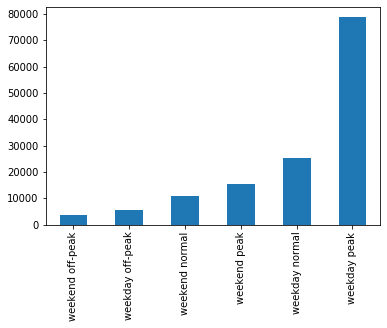

In [18]:
taxi['PricingCat'].value_counts().sort_values().plot(kind='bar')

# Plotting Milage vs. Duration

<Figure size 720x720 with 0 Axes>

(0, 60)

(0, 40)

<Figure size 720x720 with 0 Axes>

(0, 60)

(0, 40)

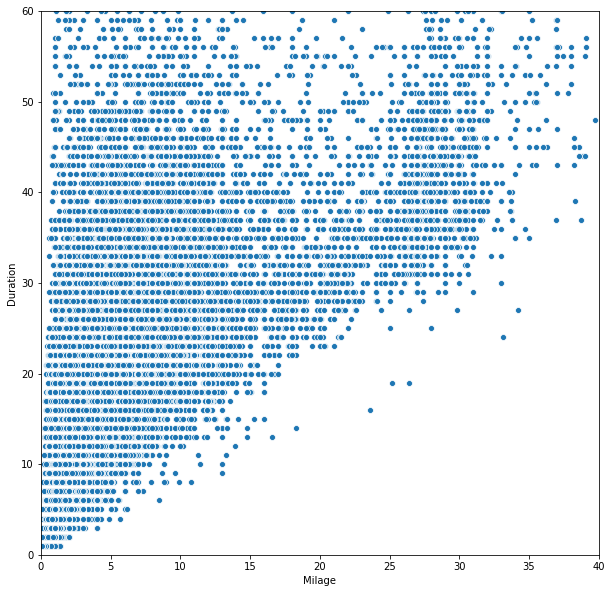

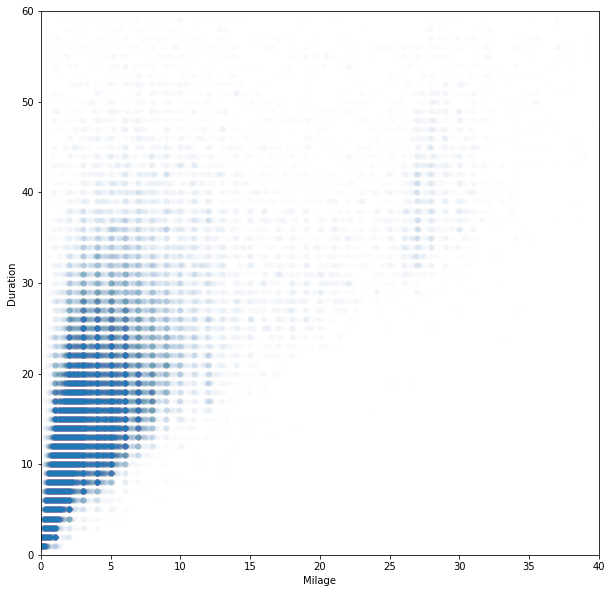

In [19]:
plt.figure(figsize=(10,10))
plt.ylim(0,60)
plt.xlim(0,40)
sb.scatterplot(data=taxi, x='Milage', y='Duration')


plt.figure(figsize=(10,10))
plt.ylim(0,60)
plt.xlim(0,40)
sb.scatterplot(data=taxi, x='Milage', y='Duration', alpha=0.01)

# Plotting Cost per Minute Rate vs. Duration

<Figure size 720x720 with 0 Axes>

(0, 6)

(0, 60)

<Figure size 720x720 with 0 Axes>

(0, 6)

(0, 60)

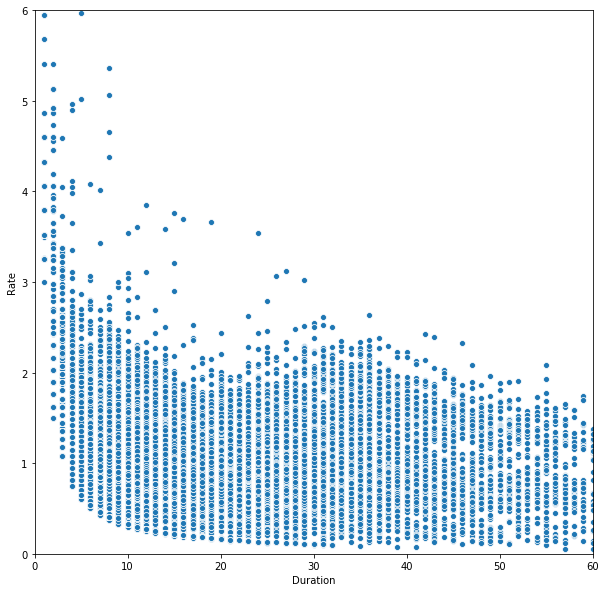

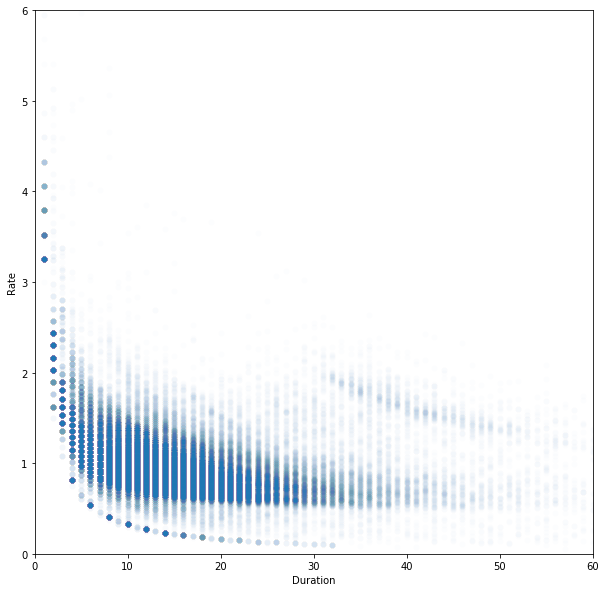

In [20]:
rate_df = taxi.copy()
rate_df['Rate'] = rate_df.FareAmount / rate_df.Duration

plt.figure(figsize=(10,10))
plt.ylim(0,6)
plt.xlim(0,60)
sb.scatterplot(data=rate_df, x='Duration', y='Rate')

plt.figure(figsize=(10,10))
plt.ylim(0,6)
plt.xlim(0,60)
sb.scatterplot(data=rate_df, x='Duration', y='Rate', alpha=0.01)

# Fitting Our Data to a Linear Regression Model to Create a Historical Pricing Model

In [21]:
df = taxi[['FareAmount', 'Milage', 'Duration']]
target = 'FareAmount'
mfn = GradientBoostingRegressor()

y = df[target]
x = df.drop(columns=[target], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

model = mfn.fit(x_train, y_train)
model.score(x_test, y_test)

0.9463129491556981

# Using our K-means and Regression Models to Calculate Surge Pricing

Using the price_trip() function:
1. Get the starting hour from the ride's timestamp
2. Use the IsWeekday boolean to get the K-means label for the particular hour
3. Map the label to the appropriate pricing dictionary to get the pricing tier and surcharge multiplier
4. Use the historical model to predict the base fare based on the milage and duration of the trip
5. Multiply the predicted fare by the pricing tier's multiplier to return the final surcharge price of the ride

In [22]:
def price_trip(trip):

    hour = trip['Hour'].values[0]

    if (trip['IsWeekday'] == 1).all():
        trip['WeekdayLabel'] = df1['WeekdayLabel'][df1.Hour == hour]
        trip['Pricing'] = weekday['WeekdayLabel'].map(weekday_pricing)
        trip['PricingCat'] = weekday['Pricing'].apply(lambda x: x.get('description'))
        trip['PricingMult'] = weekday['Pricing'].apply(lambda x: x.get('mult'))

        trip['HourMult'] = trip['WDHourMult']
    else:
        trip['WeekendLabel'] = df2['WeekendLabel'][df2.Hour == hour]
        trip['Pricing'] = weekend['WeekendLabel'].map(weekend_pricing)
        trip['PricingCat'] = weekend['Pricing'].apply(lambda x: x.get('description'))
        trip['PricingMult'] = weekend['Pricing'].apply(lambda x: x.get('mult'))

        trip['HourMult'] = trip['WEHourMult']

    trip['PredictedPrice'] = mfn.predict(trip[['Milage', 'Duration']])
    trip['PredictedPrice'] = trip['PredictedPrice'].round(2)
    trip['SurgePricing'] = trip['PredictedPrice'] * trip['PricingMult']
    trip['SurgePricing'] = trip['SurgePricing'].round(2)
    trip['HourSurgePricing'] = trip['PredictedPrice'] * trip['HourMult']
    trip['HourSurgePricing'] = trip['HourSurgePricing'].round(2)

    return trip

# Calculating Surcharge Pricing for Holdout Sample

In [23]:
holdout = taxi.sample()
new_trip = price_trip(holdout)

t = new_trip[['PROVIDER NAME', 'Date', 'DayofWeek', 'Time', 'PricingCat', 'Milage', 'Duration', 'FareAmount', 'PredictedPrice', 'PricingMult', 'SurgePricing', 'HourMult',  'HourSurgePricing']].reset_index().drop(columns=['index']).loc[0].to_frame()
t.columns = ['Trip Details']
t

,Trip Details
PROVIDER NAME,UVC
Date,2017-07-05
DayofWeek,Wednesday
Time,02:57 PM
PricingCat,weekday peak
Milage,3.4
Duration,8
FareAmount,10.81
PredictedPrice,10.84
PricingMult,3.1112


# Appendix: Creating a Pricing Model for Each Provider Using Hourly Multipliers

In [24]:
providers = list(taxi['PROVIDER NAME'].unique())

provider_dfs = [taxi[taxi['PROVIDER NAME'] == i] for i in providers]

provider_dfs = dict(zip(providers, provider_dfs))

target = 'FareAmount'
reg = GradientBoostingRegressor()

models = []
model_scores = []

for p in providers:
    df = provider_dfs[p]
    df = df[['FareAmount', 'Milage', 'Duration']]

    y = df[target]
    x = df.drop(columns=[target], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

    model = GradientBoostingRegressor().fit(x_train, y_train)
    score = model.score(x_test, y_test)
    models.append(model)
    model_scores.append(score)


provider_models = dict(zip(providers, models))

trip_preds = [i.predict(new_trip[['Milage', 'Duration']]) for i in models]

provider_preds = []

for i in range(len(trip_preds)):
    provider_preds.append(trip_preds[i][0])
    

preds_df = pd.DataFrame({'Provider': providers, 'Prediction': provider_preds})

new_trip = new_trip.reset_index()
mult = new_trip['HourMult'].values[0]
preds_df['Price'] = preds_df['Prediction'] * mult

preds_df[['Provider', 'Price']].sort_values(by='Price')

,Provider,Price
2,DC VIP Cab,14.833009
4,CMT,15.344148
8,Capitol Cab,16.095625
5,Yellow Cab,16.431548
7,My taxi Control,16.828266
6,UVC,17.086108
1,Hitch,17.548244
3,Transco,17.672179
0,VeriFone,17.933461
